#### Import packages

In [127]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# Data prepocessing

### import dataset

Dataset Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing?package=regsel&version=0.2<br>
> Before implementing the following code, make sure 'bank-additional-full.csv' is in directory './data/bank-additional'<br>
- semi-colon separated file
- read 'unknown' as na

In [134]:
# use !pwd to check the current working directory
df = pd.read_csv("./data/bank-additional/bank-additional-full.csv", sep = ';', na_values = 'unknown')

### data overview

- showing levels for categorical variables
- there are missing values in variables jon, marital, education, default, housing, loan, y

In [135]:
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' nan 'entrepreneur' 'student']
marital
['married' 'single' 'divorced' nan]
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course' nan
 'university.degree' 'illiterate']
default
['no' nan 'yes']
housing
['no' 'yes' nan]
loan
['no' 'yes' nan]
contact
['telephone' 'cellular']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
poutcome
['nonexistent' 'failure' 'success']
y
['no' 'yes']


In [136]:
print(df.isnull().sum())
print(df.columns)
print(df.shape)
print(df.info())
print(df.describe())

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
(41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  ----- 

### Data cleaning

- Shown as above: total number of missing values in job, marital, education, default, housing, loan
- Drop variables with missing values less than 1000: job, marital, housing, loan
- For variables with missing values more than 1000 (education, default), regard missing values as a new factor level
- For each categorical variables, the number of observations of each factor levels is shown as below

In [137]:
df = df[df['job'].notna()]
df = df[df['marital'].notna()]
df = df[df['housing'].notna()]
df = df[df['loan'].notna()]
df.education = df.education.fillna('unknown')
df.default = df.default.fillna('unknown')
print(df.job.value_counts())
print(df.marital.value_counts())
print(df.education.value_counts())
print(df.default.value_counts())
print(df.housing.value_counts())
print(df.loan.value_counts())

admin.           10181
blue-collar       9001
technician        6584
services          3862
management        2850
retired           1671
entrepreneur      1417
self-employed     1376
housemaid         1028
unemployed         982
student            851
Name: job, dtype: int64
married     24110
single      11215
divorced     4478
Name: marital, dtype: int64
university.degree      11821
high.school             9244
basic.9y                5856
professional.course     5100
basic.4y                4002
basic.6y                2204
unknown                 1558
illiterate                18
Name: education, dtype: int64
no         31587
unknown     8213
yes            3
Name: default, dtype: int64
yes    21376
no     18427
Name: housing, dtype: int64
no     33620
yes     6183
Name: loan, dtype: int64


- convert y, loan, housing as binary variables with level 1, 0
- perform ordinal encoding on month and day_of_week
- convert to dummy variables in the form of **VariableName_FactorLevel**: 'job', 'marital', 'education', 'contact', 'default', 'poutcome'

In [138]:
df[['y', 'loan', 'housing']] = df[['y', 'loan', 'housing']].replace('yes', 1)
df[['y', 'loan', 'housing']] = df[['y', 'loan', 'housing']].replace('no', 0)
df['month'] = df['month'].replace('mar', 0)
df['month'] = df['month'].replace('apr', 1)
df['month'] = df['month'].replace('may', 2)
df['month'] = df['month'].replace('jun', 3)
df['month'] = df['month'].replace('jul', 4)
df['month'] = df['month'].replace('aug', 5)
df['month'] = df['month'].replace('sep', 6)
df['month'] = df['month'].replace('oct', 7)
df['month'] = df['month'].replace('nov', 8)
df['month'] = df['month'].replace('dec', 9)
df['day_of_week'] = df['day_of_week'].replace('mon', 0)
df['day_of_week'] = df['day_of_week'].replace('tue', 1)
df['day_of_week'] = df['day_of_week'].replace('wed', 2)
df['day_of_week'] = df['day_of_week'].replace('thu', 3)
df['day_of_week'] = df['day_of_week'].replace('fri', 4)
cat_columns = ['job', 'marital', 'education', 'contact', 'default', 'poutcome']
for col in  cat_columns:
    df = pd.concat([df.drop(col, axis=1),
                    pd.get_dummies(df[col], prefix=col, prefix_sep='_',
                                   drop_first=True, dummy_na=False)], axis=1)
df.head()

,age,housing,loan,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_telephone,default_unknown,default_yes,poutcome_nonexistent,poutcome_success
0,56,0,0,2,0,261,1,999,0,1.1,...,0,0,0,0,0,1,0,0,1,0
1,57,0,0,2,0,149,1,999,0,1.1,...,1,0,0,0,0,1,1,0,1,0
2,37,1,0,2,0,226,1,999,0,1.1,...,1,0,0,0,0,1,0,0,1,0
3,40,0,0,2,0,151,1,999,0,1.1,...,0,0,0,0,0,1,0,0,1,0
4,56,0,1,2,0,307,1,999,0,1.1,...,1,0,0,0,0,1,0,0,1,0


In [9]:
df.y.value_counts()

0    35316
1     4487
Name: y, dtype: int64

# Model fitting

### Feature selection
- get the top 10 important variables
- correlation, random forest, xgboost

Text(0.5, 0, 'correlation Feature Importance')

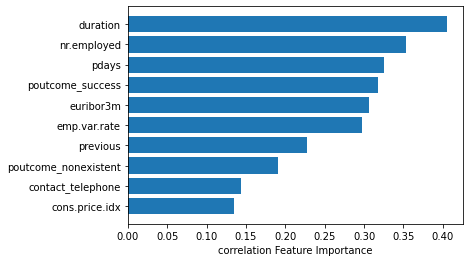

In [139]:
# remove y
cor = df.corr()['y'][:].drop(df.corr()['y'][:].index[14]).abs()

sorted_idx = cor.argsort()

plt.barh(df.drop('y', 1).columns[sorted_idx[-10:]], cor[sorted_idx[-10:]])
plt.xlabel("correlation Feature Importance")

[22:19:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 0, 'Xgboost Feature Importance')

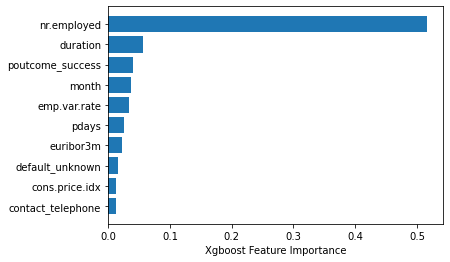

In [145]:
from xgboost import XGBClassifier
from xgboost import plot_importance

from matplotlib import pyplot
# fit model no training data
model = XGBClassifier(use_label_encoder =False)
model.fit(df.drop('y', 1), df['y'])
sorted_idx = model.feature_importances_.argsort()
plt.barh(df.drop('y', 1).columns[sorted_idx[-10:]], model.feature_importances_[sorted_idx[-10:]])
plt.xlabel("Xgboost Feature Importance")

Text(0.5, 0, 'rf Feature Importance')

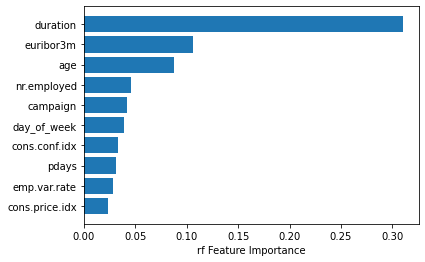

In [146]:
rf = RandomForestClassifier()
rf.fit(df.drop('y', 1), df['y'])

sorted_idx = rf.feature_importances_.argsort()
plt.barh(df.drop('y', 1).columns[sorted_idx[-10:]], rf.feature_importances_[sorted_idx[-10:]])
plt.xlabel("rf Feature Importance")

### Train/Validation/Test Split

In [148]:
#convert the response variable to categorical variable
X = df.drop('y',axis = 1).values[:, sorted_idx[-10:]]
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify = y)

X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

print('Train/Valid/Test sizes:', y_train.shape, y_valid.shape, y_test.shape)

Train/Valid/Test sizes: (29852,) (5971,) (9951,)


#### Help function
- conf_matrix: return a pretty plot of confusion matrix
- get_scores: return accuracy, 

In [ ]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3,3))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False)
    plt.title('Accept Deposit?')
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

### Baseline model --logistic regression

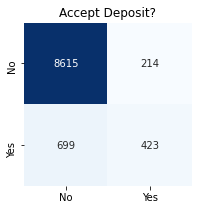

In [122]:
from sklearn.linear_model import LogisticRegression
glr_model = LogisticRegression(max_iter = 300)
glr_model.fit(pd.DataFrame(X_train[:, :10]), y_train)
y_pred_glr = glr_model.predict(pd.DataFrame(X_test[:,:10]))
accuracy_score(y_test,y_pred_glr)

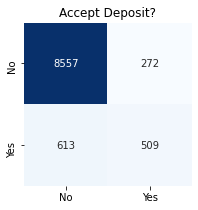

In [87]:
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
conf_matrix(y_test,y_pred_knn)

In [88]:
scores_knn = get_scores(y_test,y_pred_knn)
scores_knn

,scores
Accuracy,0.91
Precision,0.65
Recall,0.45
F1,0.53
ROC AUC,0.71


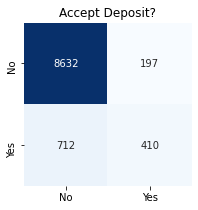

In [89]:
from sklearn.svm import SVC
abc = AdaBoostClassifier(n_estimators=800, learning_rate=0.1, random_state=123)
abc.fit(X_train, y_train)
y_pred_abc = abc.predict(X_test)
conf_matrix(y_test, y_pred_abc)

In [90]:
get_scores(y_test, y_pred_abc)

,scores
Accuracy,0.91
Precision,0.68
Recall,0.37
F1,0.47
ROC AUC,0.67


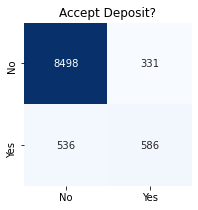

In [92]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)
conf_matrix(y_test, y_pred_rfc)

In [93]:
get_scores(y_test, y_pred_rfc)

,scores
Accuracy,0.91
Precision,0.64
Recall,0.52
F1,0.57
ROC AUC,0.74


In [94]:
xgb_model = xgb.XGBClassifier(n_estimators=3000, max_depth=4, learning_rate=0.01)
xgb_model.fit(X_train, y_train)

/Users/zhaoxingwu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:47:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

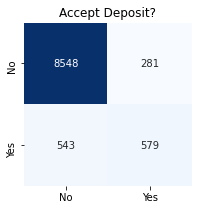

In [95]:
y_pred_xgb = xgb_model.predict(X_test)
conf_matrix(y_test, y_pred_xgb)

In [96]:
get_scores(y_test, y_pred_xgb)

,scores
Accuracy,0.92
Precision,0.67
Recall,0.52
F1,0.58
ROC AUC,0.74
